<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Deep Learning School FPMI MIPT</b></h3>

<h3 style="text-align: center;"><b>Generative adversarial networks</b></h3>



This is second attempt of making GAN NN

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import torch.nn.parallel
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import exists
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import random
from sklearn.model_selection import train_test_split
#import skimage.io
#from skimage.transform import resize
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Part 1. Data prepare

In [ ]:
!pip install gdown
!git clone https://github.com/NVlabs/ffhq-dataset.git
import gdown
url = 'https://drive.google.com/uc?id=16N0RV4fHI6joBuKbQAoG34V_cQk7vxSA'
output = './ffhq-dataset-v2.json'
gdown.download(url, output, quiet=False)
!python3 ./ffhq-dataset/download_ffhq.py -t --num_threads 32 -j

^C
ERROR: Operation cancelled by user
fatal: destination path 'ffhq-dataset' already exists and is not an empty directory.


Downloading...
From: https://drive.google.com/uc?id=16N0RV4fHI6joBuKbQAoG34V_cQk7vxSA
To: /home/iahve/ffhq-dataset-v2.json
100%|████████████████████████████████████████████████████████████████████████████████| 268M/268M [00:23<00:00, 11.3MB/s]


Parsing JSON metadata...
All files already downloaded -- skipping.


In [2]:
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ffhd_Dataset(Dataset):

  def __init__(self, files, transform, image_size):
        super().__init__()
        self.transform = transform
        self.files = files
        self.len_ = len(self.files)
        self.image_size = image_size

  def __len__(self):
      return self.len_

  def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

  def _prepare_sample(self, image):
        #image = image.resize((self.image_size, self.image_size))
        return np.array(image)

  def __getitem__(self, index):
        transform = self.transform
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        return x

In [3]:
workers = 8

def get_dataloader(image_size, batch_size, data_size, stats= None):
  if not os.path.exists("ffhq-dataset-v2.json"):
    print("attributes not found, downloading...")
    return
  #read attrs
  df_attrs = pd.read_json("ffhq-dataset-v2.json", orient='index') 
  database_len = len(df_attrs)
  if data_size <=0 or data_size > database_len:
    print("database is shorter than data_size")
    return
  print('found images ', database_len)
  image_indexes = random.sample(range(database_len), data_size) 
  print('will be loaded', len(image_indexes))
  train_indexes, test_indexes = train_test_split(image_indexes, test_size=0.25)
  test_indexes, val_indexes = train_test_split(test_indexes, test_size=0.5)
  
  train_df_attrs = pd.DataFrame(df_attrs.iloc[train_indexes]['thumbnail'].values.tolist()) 
  test_df_attrs = pd.DataFrame(df_attrs.iloc[test_indexes]['thumbnail'].values.tolist()) 
  val_df_attrs = pd.DataFrame(df_attrs.iloc[val_indexes]['thumbnail'].values.tolist()) 
  print('train_dataloader len = ', len(train_df_attrs))
  print('test_df_attrs len = ', len(test_df_attrs))
  print('val_df_attrs len = ', len(val_df_attrs))
  

  if stats is not None:
    transform = tt.Compose([
            tt.ToTensor(),
            tt.Resize(image_size),
            tt.CenterCrop(image_size),
            tt.Normalize(*stats) 
            ])
  else:
    transform = tt.Compose([
            tt.ToTensor(),
            tt.Resize(image_size),
            tt.CenterCrop(image_size),
            ])
  train_dataset = ffhd_Dataset(train_df_attrs['file_path'],transform, image_size)
  test_dataset = ffhd_Dataset(test_df_attrs['file_path'],transform, image_size)
  val_dataset = ffhd_Dataset(val_df_attrs['file_path'],transform, image_size)

  del df_attrs
  del image_indexes

  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = workers)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers = workers)
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers = workers)
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  return train_dataloader, test_dataloader, val_dataloader

In [4]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=32):
    #print(images.shape)
    #images=images.permute(0,3, 1, 2) 
    print(images.shape)
    fig, ax = plt.subplots(figsize=(4, 8), dpi=400)
    ax.set_xticks([]); ax.set_yticks([])
    #ax.imshow(make_grid(images.detach(),normalize=True).permute(1, 2, 0))
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8, normalize=True).permute(1, 2, 0))
    plt.show()

def show_batch(dl, nmax=32):
    for images in dl:
        show_images(images, nmax)
        break
def generate_images(gen, xb = None):
  if xb is None:
    xb = torch.randn(batch_size, latent_size, 1, 1) 
  #torch.cuda.empty_cache()
  #gen.eval()
  fake_images = gen(xb.to(device))
  show_images(fake_images.cpu())
  #torch.cuda.empty_cache()
  del fake_images

In [ ]:
image_size = 128
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_dataloader, test_dataloader, val_dataloader = get_dataloader(image_size, batch_size, 10000, stats)

show_batch(train_dataloader, batch_size)
show_batch(test_dataloader, batch_size)
show_batch(val_dataloader, batch_size)

## Part 2. Building and training the model

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
ngpu = 1
latent_size = 256 # choose latent size
# Size of feature maps in generator
ngf = 16
# Size of feature maps in discriminator
ndf = 32#38



cuda


In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class NETWrapper(nn.Module):
  def Save(self, path):
    torch.save(self.state_dict(), path)

  def Load(self, path):
    if exists(path):
      self.load_state_dict(torch.load(path))
      print('model loaded from ', path)
  def prepare(self, weight_prepare):
      # Handle multi-gpu if desired
    print('self.device.type equals to ', self.device.type)
    print('ngpu equals to ', self.ngpu)
    self.to(self.device)
    #if (self.device.type == 'cuda') and (self.ngpu > 1):
      #self = nn.DataParallel(self, list(range(self.ngpu)))
    if weight_prepare is True:
      self.apply(weights_init)
  def __init__(self, ngpu, device):
    super(NETWrapper, self).__init__()
    self.ngpu = ngpu
    self.device = device

In [9]:
class Discriminator(NETWrapper):
  def __init__(self, ngpu, device, path = None):
    super(Discriminator, self).__init__(ngpu, device)
    self.convs = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
    self.last_conv = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Flatten(),
            nn.Sigmoid()
        )
    self.prepare(True)
    if path is not None:
      self.Load(path)
  def forward(self, x):

        f_d = self.convs(x)
        x = self.last_conv(f_d)
        return x


In [10]:
# Create the generator
netD = Discriminator(ngpu, device)

print(netD)


self.device.type equals to  cuda
ngpu equals to  1
Discriminator(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

Discriminator check

In [103]:
xb = torch.randn(batch_size,3,128,128) 
print(xb.shape)
answers = netD(xb.to(device))
print(answers.shape)
del answers

torch.Size([64, 3, 128, 128])
torch.Size([64, 1])


In [11]:
class Generator(NETWrapper):
    def __init__(self, ngpu, device, path = None):

        super(Generator, self).__init__(ngpu, device)

        self.convs = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, 4, 1, 0, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 384, 4, 2, 1, bias=False),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(384, 192, 4, 2, 1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(192, 96, 4, 2, 1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.prepare(True)
        if path is not None:
          self.Load(path)
    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        x_gen = self.convs(z)
        return x_gen


In [12]:
# Create the generator
netG = Generator(ngpu, device)

print(netG)

self.device.type equals to  cuda
ngpu equals to  1
Generator(
  (convs): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(96, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

Generator check

In [ ]:
generate_images(netG)

In [13]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [14]:
fixed_latent = torch.randn(64, latent_size, device=device)

In [15]:
def save_samples(gen, index, latent_tensors, show=True):
    fake_images = gen(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
#netG.Load('./GAN/netG_epoch99')
#netD.Load('./GAN/netD_epoch99')

model loaded from  ./GAN/netG_epoch99
model loaded from  ./GAN/netD_epoch99


In [105]:
lr = 0.0002

model = {
    "discriminator": netD,
    "generator": netG
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
    # Create optimizers
optimizer = {
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(), lr=lr, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(model["generator"].parameters(), lr=lr, betas=(0.5, 0.999))
}

In [106]:

def fit(model, criterion, epochs, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(train_dataloader):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images.to(device))
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            #print('real_preds.shape = ', real_preds.shape)
            #print('real_targets.shape = ', real_targets.shape)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            noise = torch.randn(fake_images.size(0),1, device=device) * 0.05 + 0.05
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)+ noise
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.detach().item())
            del loss_d
            del real_loss
            del fake_loss


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            noise = torch.rand(fake_images.size(0), 1, device=device) * 0.05 + 0.05
            targets = torch.ones(batch_size, 1, device=device) - noise
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            del real_images
            del fake_images
            del loss_g
        generate_images(model["generator"], fixed_latent)
        torch.cuda.empty_cache()
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        model["discriminator"].Save('./GAN/netD_epoch{}'.format(epoch))
        model["generator"].Save('./GAN/netG_epoch{}'.format(epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(model["generator"],epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
epochs = 100

history = fit(model, criterion, epochs)

In [ ]:
#netG.Load('./GAN/netG_epoch0')
#generate_images(netG)

In [19]:
losses_g, losses_d, real_scores, fake_scores = history

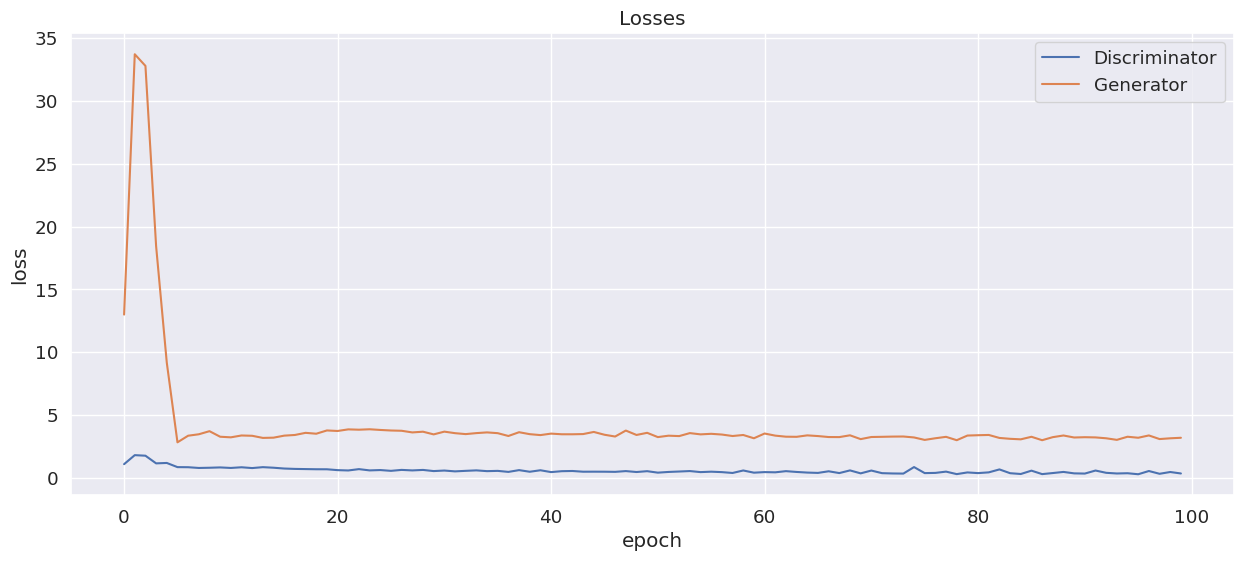

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Losses much better than in first attempt

In [21]:
print(f'./generated/generated-images-0{epochs}.png')
generated_img = cv2.imread(f'./generated/generated-images-0{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

./generated/generated-images-0100.png


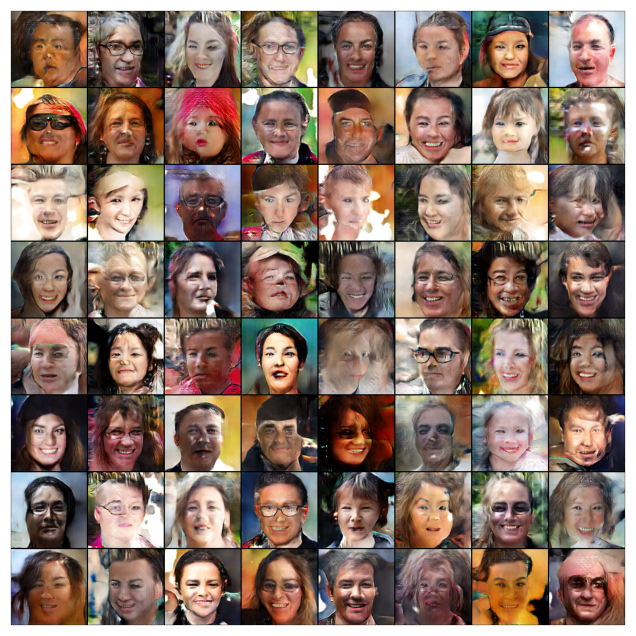

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Faces are not much better, but better tho

## Part 3. Image generation

torch.Size([4, 3, 128, 128])


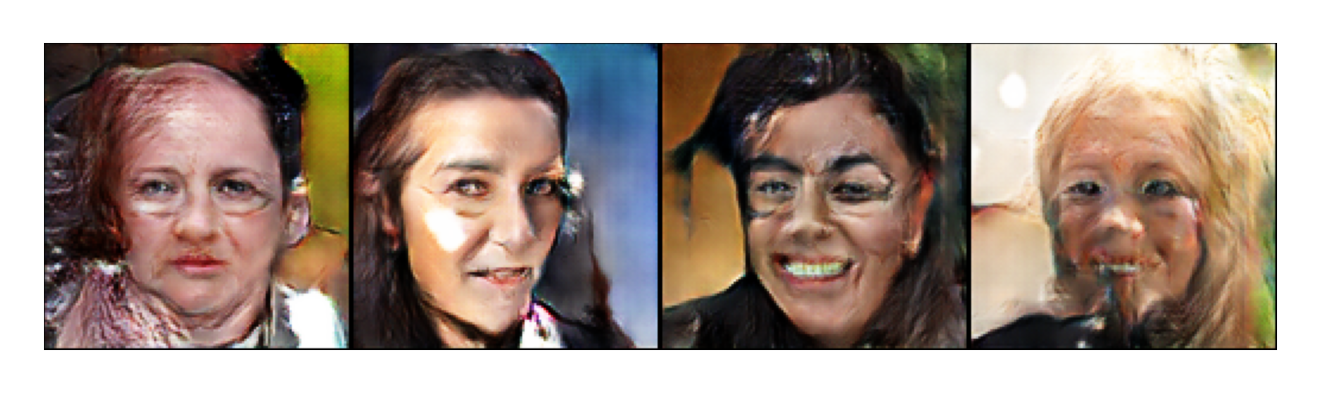

In [23]:
n_images = 4
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
generate_images(model["generator"], fixed_latent)

Pretty creepy still :) but without dark blur and more humanized

## Part 4. Leave-one-out-1-NN classifier accuracy

In [24]:
dim_code = 2048

In [25]:
encoder_lay = 64
decoder_lay = 64

class Autoencoder(NETWrapper):
    def __init__(self, ngpu, device, path = None):
        #<определите архитектуры encoder и decoder>
        super(Autoencoder, self).__init__(ngpu, device)
        #self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
                      # input is (nc) x 64 x 64
            nn.Conv2d(3, encoder_lay, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(encoder_lay, encoder_lay * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(encoder_lay * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(encoder_lay * 2, encoder_lay * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(encoder_lay * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(encoder_lay * 4, encoder_lay * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(encoder_lay * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(encoder_lay * 8, encoder_lay * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(encoder_lay * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(encoder_lay * 16, latent_size, 1, 1, 0, bias=False),
            nn.Flatten(),
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([16, 16, 16])),
            #nn.ConvTranspose2d( 16, decoder_lay * 16, 4, 1, 0, bias=False),
            #nn.BatchNorm2d(decoder_lay * 16),
            #nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(16, decoder_lay * 8, 4, 1, 1, bias=False),
            nn.BatchNorm2d(decoder_lay * 8),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( decoder_lay * 8, decoder_lay * 4, 4, 1, 2, bias=False),
            nn.BatchNorm2d(decoder_lay * 4),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( decoder_lay * 4, decoder_lay * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(decoder_lay * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( decoder_lay * 2, decoder_lay, 4, 2, 1, bias=False),
            nn.BatchNorm2d(decoder_lay),
            nn.ReLU(True),

            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( decoder_lay, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.prepare(False)

    def forward(self, x):
        latent_code = self.encoder(x)
        #print('latent_code shape', latent_code.shape)
        reconstruction = self.decoder(latent_code)
        #print('reconstruction shape', reconstruction.shape)
        return reconstruction, latent_code

In [108]:
criterion = torch.nn.functional.mse_loss

autoencoder = Autoencoder(1, device)

VAE_optimizer = torch.optim.AdamW(autoencoder.parameters(),lr=0.001)#<Ваш любимый оптимизатор>

self.device.type equals to  cuda
ngpu equals to  1


In [ ]:
from tqdm.notebook import tqdm
n_epochs = 300
VAE_train_losses = []
VAE_val_losses = []

static_image = next(iter(val_dataloader))

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for X_batch in test_dataloader:
        VAE_optimizer.zero_grad()
        reconstructed, _ = autoencoder(X_batch.to(device))
        loss = criterion(reconstructed, X_batch.to(device))
        loss.backward()
        VAE_optimizer.step()
        train_losses_per_epoch.append(loss.cpu().detach().item())
        del X_batch
        del reconstructed
    torch.cuda.empty_cache()
    VAE_train_losses.append(np.mean(train_losses_per_epoch))
    print('epoch {}, train losss = {}'.format(epoch, np.mean(train_losses_per_epoch)))

    reconstructed, _ = autoencoder(static_image.to(device))
    plt.subplot(2, 6, 1)
    plt.axis("off")
    plt.imshow( reconstructed[0].permute(1, 2, 0).cpu().detach().numpy()  )
    plt.subplot(2, 6, 2)
    plt.axis("off")
    plt.imshow( static_image[0].permute(1, 2, 0).cpu().detach().numpy()  )
    plt.show();
    del reconstructed

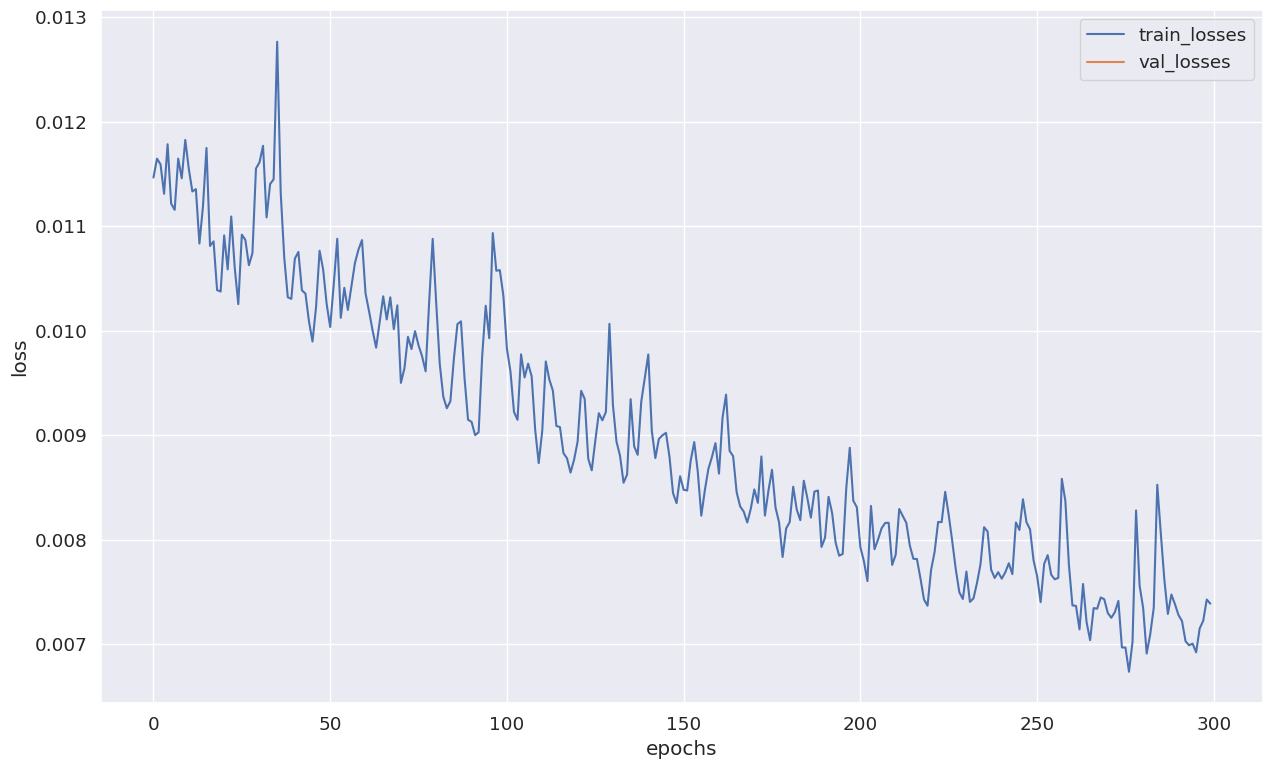

In [118]:
plt.figure(figsize=(15, 9))
#plt.ylim(0.0, 3300)
plt.plot(VAE_train_losses, label="train_losses")
plt.plot(VAE_val_losses, label="val_losses")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([64, 3, 128, 128])


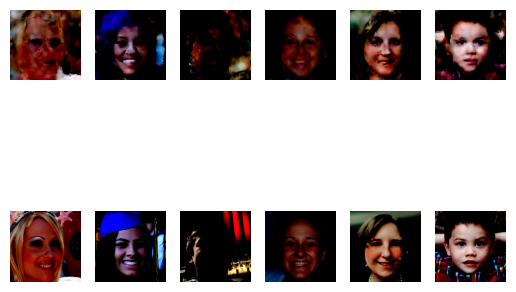

In [119]:
for X_batch in val_dataloader:
          autoencoder.eval()
          reconstruction, _, = autoencoder(X_batch.to(device))
          origin_image = X_batch
          break
print(origin_image.shape)
for i in range(6):
    image = reconstruction[i]#(reconstruction[i] * (2 + 0.0002)) - 1.00001
    plt.subplot(2, 6, 1 + i)
    plt.axis("off")
    plt.imshow( image.permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 6, 7 + i)
    plt.axis("off")
    plt.imshow( origin_image[i].permute(1, 2, 0).cpu().detach().numpy())
plt.show();

In [112]:
generated_images =[]
for i in range(len(test_dataloader)* batch_size):
  model["generator"].eval()
  new_latent = torch.randn(1, latent_size, 1, 1, device=device)
  gen_image = model["generator"](new_latent).detach().cpu()
  generated_images.append(gen_image[0,])
  del new_latent
  del gen_image

generated_dataloader = torch.utils.data.DataLoader(generated_images, batch_size=batch_size, shuffle=True, num_workers = workers)

len(generated_images)

1280

In [120]:
latent = []
Y_values = []
autoencoder = autoencoder.to(device)

for X_batch, gen_X_batch in zip(val_dataloader, generated_dataloader):
          autoencoder.eval()
          X_batch = torch.cat((X_batch, gen_X_batch), 0)
          X_batch = X_batch.to(device)
          r,l = autoencoder(X_batch)
          latent.append(l.cpu().detach())
          real_targets = torch.ones(len(X_batch) - len(gen_X_batch), 1, device=device)
          fake_targets = torch.zeros(len(gen_X_batch), 1, device=device)
          Y_values.append(real_targets)
          Y_values.append(fake_targets)
          del X_batch
          del l
          del r
          torch.cuda.empty_cache()

In [121]:
t = torch.cat(latent,0).cpu()
labels = torch.cat(Y_values, 0).cpu()

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(t)
X_embedded = torch.tensor(X_embedded)
X_embedded = torch.cat((X_embedded, labels),1)
X_embedded

tensor([[ 69.3354, -10.2109,   1.0000],
        [ 39.7666, -58.6222,   1.0000],
        [-65.3984,  30.7389,   1.0000],
        ...,
        [ -0.2921, -26.1658,   0.0000],
        [  0.1497, -34.3620,   0.0000],
        [-31.7964,  -5.2533,   0.0000]])

In [122]:
count = 0
for i in range(len(X_embedded)):
  new_array = torch.cat((X_embedded[:i,:] , X_embedded[i+1:,:]), 0)
  target = X_embedded[i,:]
  neigh = KNeighborsClassifier(n_neighbors=1)
  neigh.fit(new_array[:,0:2], new_array[:,2])
  pred = neigh.predict(target[None,:2])
 #print(target[None,:2])
 #print(pred[0] == target[2])
  count += pred[0] == target[2]

score = float(count/len(X_embedded))
print('knn score is ', score)



knn score is  0.769565224647522


Non-images are distinguishable by the autoencoder with fairly high accuracy. It can be improved by training on the entire sample of 70,000 images and increasing the network parameters. Also, we may try MSE as a loss function. I think that this will greatly improve the quality, but it will take more time to learn.

### 4.2. Visualization of distributions

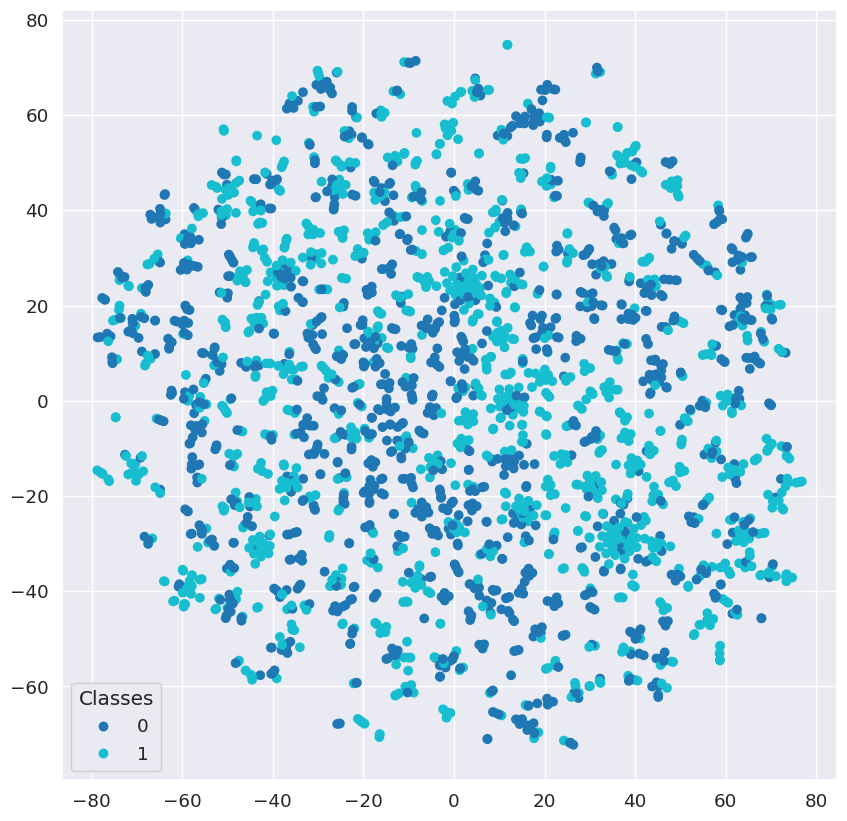

In [123]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=X_embedded[:, 2], cmap='tab10')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1);

Result is much better than in the first attempt, generated images are hardly distinguishable with the real ones. Picture quality, however, is still far from ideal. If we would have resources and time, we could try measures to improve the quality of generated images in the way described above